### Autoencoders for rare events

Here we will train a binary classification model using Autoencoders. The objective is to train a model capable of classifying a rarely occurring event, for which we have hardly any data. This code is based on https://www.viralml.com/

In [1]:
#https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score
from pandas.api.types import is_numeric_dtype
import urllib

In [2]:
url="http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
raw_data = urllib.request.urlopen(url)
credit=pd.DataFrame(raw_data)
data = pd.read_csv(url, delimiter=' ', header=None)

In [3]:
data.columns = ['HasChecking', 'DurationInMonths', 'CreditHistory', 'CreditPurpose', 'CreditAmount', 
         'SavingsAccount', 'EmployedSince', 'InstallmentRatePercentIncome', 'StatusGender', 
        'OtherDebtorsGuarantors', 'ResidenceSince', 'Property', 'Age', 'OtherInstallmentPlans', 'Housing', 
         'NumberExistingCredits', 'Job', 'FamilyLiablities', 'HasPhone', 'ForeignWorker', 'CreditRisk']
data.head()

,HasChecking,DurationInMonths,CreditHistory,CreditPurpose,CreditAmount,SavingsAccount,EmployedSince,InstallmentRatePercentIncome,StatusGender,OtherDebtorsGuarantors,...,Property,Age,OtherInstallmentPlans,Housing,NumberExistingCredits,Job,FamilyLiablities,HasPhone,ForeignWorker,CreditRisk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
# Quick untangle of categorical data
numerical_features = [f for f in list(data) if is_numeric_dtype(data[f])]
numerical_features

['DurationInMonths',
 'CreditAmount',
 'InstallmentRatePercentIncome',
 'ResidenceSince',
 'Age',
 'NumberExistingCredits',
 'FamilyLiablities',
 'CreditRisk']

In [5]:
non_numerical_features = [f for f in list(data) if f not in numerical_features]
non_numerical_features

['HasChecking',
 'CreditHistory',
 'CreditPurpose',
 'SavingsAccount',
 'EmployedSince',
 'StatusGender',
 'OtherDebtorsGuarantors',
 'Property',
 'OtherInstallmentPlans',
 'Housing',
 'Job',
 'HasPhone',
 'ForeignWorker']

In [6]:
## Pre-process categorical variables 
# make dummy vars out of non_numerical_features
data_ready = pd.get_dummies(data, columns=non_numerical_features, 
               drop_first=False,
               dummy_na=False)
print(data_ready.shape)
data_ready.head()

(1000, 62)


,DurationInMonths,CreditAmount,InstallmentRatePercentIncome,ResidenceSince,Age,NumberExistingCredits,FamilyLiablities,CreditRisk,HasChecking_A11,HasChecking_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,HasPhone_A191,HasPhone_A192,ForeignWorker_A201,ForeignWorker_A202
0,6,1169,4,4,67,2,1,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,2,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,2,1,0,...,0,1,0,0,1,0,1,0,1,0


In [7]:
##What is the sum of these variables based on credit risk?'CreditRisk','HasChecking_A11','HasChecking_A12','HasChecking_A13','HasChecking_A14']]
# from data notes we know that: (1 = Good, 2 = Bad)
data_ready[['CreditRisk','HasChecking_A11',
            'HasChecking_A12',
            'HasChecking_A13',
           'HasChecking_A14']].groupby('CreditRisk').sum()

,HasChecking_A11,HasChecking_A12,HasChecking_A13,HasChecking_A14
CreditRisk,,,,
1,139.0,164.0,49.0,348.0
2,135.0,105.0,14.0,46.0


In [8]:
# fix binary outcome - good versus bad credit risk
# from data notes we know that: (1 = Good, 2 = Bad) so 0 will be good credit and 1 will be bad credit
data_ready['CreditRisk'].replace([1,2], [0,1], inplace=True)
data_ready['CreditRisk'].value_counts()

0    700
1    300
Name: CreditRisk, dtype: int64

In [9]:
print(data_ready.shape)
features = [f for f in list(data_ready) if f not in ['CreditRisk']]
print(len(features))

## Split between train and test
X_train, X_test, Y_train, Y_test = train_test_split(data_ready[features],
                                                    data_ready['CreditRisk'],
                                                    test_size=0.3, 
                                                    random_state=1)

(1000, 62)
61


In [10]:
## Get the datasets of X_train_0 and X_test_0 where there are only data of class 0
# Create set of normal outcomes only
X_train_0 = X_train.copy()
X_train_0['CreditRisk'] = Y_train
X_train_0 = X_train_0[X_train_0['CreditRisk']==0]
X_train_0 = X_train_0.drop('CreditRisk', axis=1)

X_test_0 = X_test.copy()
X_test_0['CreditRisk'] = Y_test
X_test_0 = X_test_0[X_test_0['CreditRisk']==0]
X_test_0 = X_test_0.drop('CreditRisk', axis=1)

In [11]:
# Auto encoder parameters
nb_epoch = 500
batch_size = 128
input_dim = X_train_0.shape[1]
encoding_dim = 24
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

# set up autoencoder layers
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61)]              0         
                                                                 
 dense (Dense)               (None, 24)                1488      
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 12)                156       
                                                                 
 dense_3 (Dense)             (None, 24)                312       
                                                                 
 dense_4 (Dense)             (None, 61)                1525      
                                                  

2022-07-24 19:41:55.399083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-24 19:41:55.399228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
## Compile
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(X_train_0, X_train_0,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_0, X_test_0),
                    verbose=1,
                    callbacks=[cp, tb]).history

## Autoencoder training

Epoch 1/500


2022-07-24 19:41:55.583021: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-24 19:41:55.833177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 84ms/step - loss: 250083.0938 - accuracy: 0.0000e+00 - val_loss: 258763.1094 - val_accuracy: 0.0000e+00
Epoch 2/500
4/4 [==============================] - 0s 25ms/step - loss: 243258.3281 - accuracy: 0.0000e+00 - val_loss: 253664.8125 - val_accuracy: 0.0000e+00
Epoch 3/500
1/4 [======>.......................] - ETA: 0s - loss: 310595.3125 - accuracy: 0.0000e+00

2022-07-24 19:41:56.194959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 20ms/step - loss: 239927.1406 - accuracy: 0.0000e+00 - val_loss: 252055.5781 - val_accuracy: 0.0000e+00
Epoch 4/500
4/4 [==============================] - 0s 20ms/step - loss: 238609.6719 - accuracy: 0.0000e+00 - val_loss: 250923.9062 - val_accuracy: 0.0000e+00
Epoch 5/500
4/4 [==============================] - 0s 25ms/step - loss: 237598.5469 - accuracy: 0.0000e+00 - val_loss: 249961.7812 - val_accuracy: 0.0000e+00
Epoch 6/500
4/4 [==============================] - 0s 44ms/step - loss: 236772.3125 - accuracy: 0.0000e+00 - val_loss: 249208.3906 - val_accuracy: 0.0000e+00
Epoch 7/500
4/4 [==============================] - 0s 23ms/step - loss: 236094.3594 - accuracy: 0.0000e+00 - val_loss: 248528.7812 - val_accuracy: 0.0000e+00
Epoch 8/500
4/4 [==============================] - 0s 21ms/step - loss: 235415.6250 - accuracy: 0.0000e+00 - val_loss: 247845.4375 - val_accuracy: 0.0000e+00
Epoch 9/500
4/4 [==============================] - 0s 23ms/step 

In [13]:
## Calculate the mse
test_x_predictions = autoencoder.predict(X_test)
print(test_x_predictions.shape)

mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
mse

10/10 [==============================] - 0s 3ms/step
(300, 61)


2022-07-24 19:42:31.942158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507     16.094130
818    148.585533
452      2.663250
368      9.211005
242     14.227515
          ...    
459      1.645761
415      2.546961
61      22.859326
347      1.407396
349      8.299540
Length: 300, dtype: float64

In [14]:
Y_test.value_counts()

0    214
1     86
Name: CreditRisk, dtype: int64

In [15]:
fpr, tpr, thresholds = roc_curve(Y_test, mse)
print('thresholds', np.mean(thresholds))

print('AUC', auc(fpr, tpr))

thresholds 18.55459012742062
AUC 0.5972614648989351


In [16]:
threshold_fixed = 21.05
## Calculate the AUC for a threshold of 21.05
print('AUC', accuracy_score(Y_test, [1 if s > threshold_fixed else 0 for s in mse]))

AUC 0.68


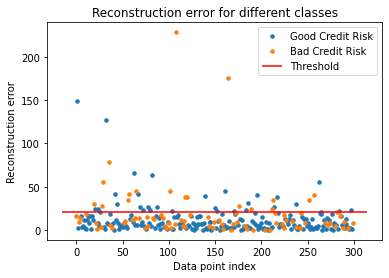

In [17]:
## Obtain the reconstruction error graph for the different classes
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_test})
error_df_test = error_df_test.reset_index()

groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Bad Credit Risk" if name == 1 else "Good Credit Risk")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", 
          zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

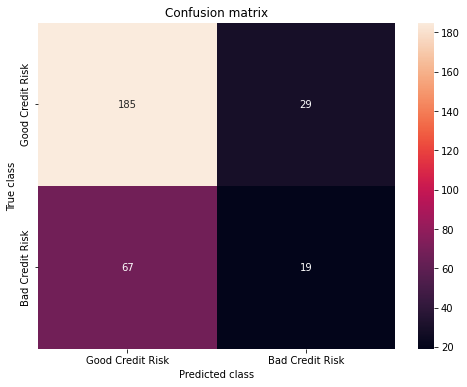

In [18]:
## Displays the confusion matrix
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test['Reconstruction_error'].values]
conf_matrix = confusion_matrix(error_df_test['True_class'], pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, 
            xticklabels=["Good Credit Risk","Bad Credit Risk"], 
            yticklabels=["Good Credit Risk","Bad Credit Risk"], 
            annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

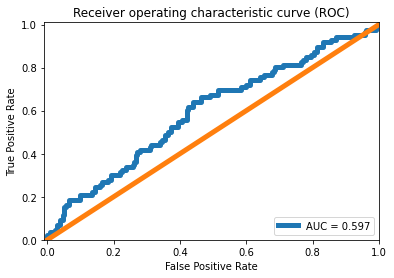

In [19]:
## Get the ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df_test['True_class'], 
                                                      error_df_test['Reconstruction_error'])
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Anomalies

In [20]:
# What are some of those features that we see via poor reconstruction error?
X_test['Error'] = mse
X_test['CreditRisk'] = Y_test
X_test = X_test.sort_values('Error', ascending=False)
X_test.head()

,DurationInMonths,CreditAmount,InstallmentRatePercentIncome,ResidenceSince,Age,NumberExistingCredits,FamilyLiablities,HasChecking_A11,HasChecking_A12,HasChecking_A13,...,Job_A171,Job_A172,Job_A173,Job_A174,HasPhone_A191,HasPhone_A192,ForeignWorker_A201,ForeignWorker_A202,Error,CreditRisk
236,6,14555,1,2,23,1,1,0,1,0,...,1,0,0,0,0,1,1,0,228.325962,1
887,48,15672,2,2,23,1,1,0,1,0,...,0,0,1,0,0,1,1,0,175.923767,1
818,36,15857,2,3,43,1,1,1,0,0,...,0,0,0,1,1,0,1,0,148.585533,0
744,39,14179,4,4,30,2,1,1,0,0,...,0,0,0,1,0,1,1,0,126.854731,0
274,30,11998,1,1,34,1,1,1,0,0,...,0,1,0,0,0,1,1,0,79.088920,1


In [21]:
## What is the average of the variables for normal credit?
normal_values = X_test[X_test['CreditRisk']==0].mean()
normal_values

DurationInMonths                  19.191589
CreditAmount                    3053.785047
InstallmentRatePercentIncome       3.018692
ResidenceSince                     2.808411
Age                               35.542056
                                   ...     
HasPhone_A192                      0.425234
ForeignWorker_A201                 0.943925
ForeignWorker_A202                 0.056075
Error                             11.585038
CreditRisk                         0.000000
Length: 63, dtype: float64

In [22]:
diff_values = normal_values - X_test.head(10)
diff_values = diff_values.T
diff_values

,236,887,818,744,274,395,756,187,374,205
DurationInMonths,13.191589,-28.808411,-16.808411,-19.808411,-10.808411,-19.808411,13.191589,3.191589,-40.808411,-10.808411
CreditAmount,-11501.214953,-12618.214953,-12803.214953,-11125.214953,-8944.214953,-8706.214953,1754.785047,1878.785047,-11728.214953,-7569.214953
InstallmentRatePercentIncome,2.018692,1.018692,1.018692,-0.981308,2.018692,1.018692,2.018692,1.018692,0.018692,0.018692
ResidenceSince,0.808411,0.808411,-0.191589,-1.191589,1.808411,-0.191589,1.808411,-0.191589,-1.191589,-1.191589
Age,12.542056,12.542056,-7.457944,5.542056,1.542056,3.542056,-38.457944,-32.457944,-24.457944,-2.457944
...,...,...,...,...,...,...,...,...,...,...
HasPhone_A192,-0.574766,-0.574766,0.425234,-0.574766,-0.574766,-0.574766,0.425234,-0.574766,-0.574766,-0.574766
ForeignWorker_A201,-0.056075,-0.056075,-0.056075,-0.056075,-0.056075,-0.056075,0.943925,-0.056075,-0.056075,-0.056075
ForeignWorker_A202,0.056075,0.056075,0.056075,0.056075,0.056075,0.056075,-0.943925,0.056075,0.056075,0.056075
Error,-216.740923,-164.338728,-137.000494,-115.269693,-67.503882,-54.679181,-52.225540,-43.571729,-43.484479,-34.075805


In [23]:
customer = 236
## Analyze customer 236 in which variables does it differ most significantly from normal customers?
to_analyze = pd.DataFrame(diff_values[customer])
to_analyze = to_analyze.sort_values(customer, ascending=True)
print(to_analyze.head(1))
print(to_analyze.tail(1))

                       236
CreditAmount -11501.214953
                        236
DurationInMonths  13.191589
